# COMPARING BASELINE TO THIS APPROACH

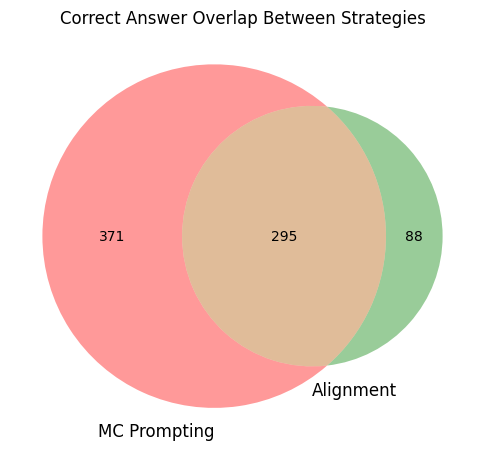

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# === Load both results ===
mc_df = pd.read_csv("output/answered_llama3.2.csv")
align_df = pd.read_csv("output/alignment_eval_llama3.2.csv")

# === Preprocess ===
mc_df["Predicted"] = mc_df["Predicted"].str.strip().str.upper()
mc_df["Answer"] = mc_df["Answer"].str.strip().str.upper()
align_df["Predicted"] = align_df["Predicted"].str.strip().str.upper()
align_df["CorrectAnswer"] = align_df["CorrectAnswer"].str.strip().str.upper()

# === Merge on question index ===
mc_df["OriginalIndex"] = mc_df.index
merged = pd.merge(mc_df, align_df, on="OriginalIndex", suffixes=("_MC", "_Align"))

# === Evaluate Accuracy ===
merged["MC_Correct"] = merged["Predicted_MC"] == merged["Answer"]
merged["Align_Correct"] = merged["Predicted_Align"] == merged["CorrectAnswer"]

# === Set counts for Venn
only_mc = ((merged["MC_Correct"]) & (~merged["Align_Correct"])).sum()
only_align = ((merged["Align_Correct"]) & (~merged["MC_Correct"])).sum()
both = ((merged["MC_Correct"]) & (merged["Align_Correct"])).sum()

# === Plot Venn Diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(only_mc, only_align, both), set_labels=("MC Prompting", "Alignment"))
plt.title("Correct Answer Overlap Between Strategies")
plt.show()


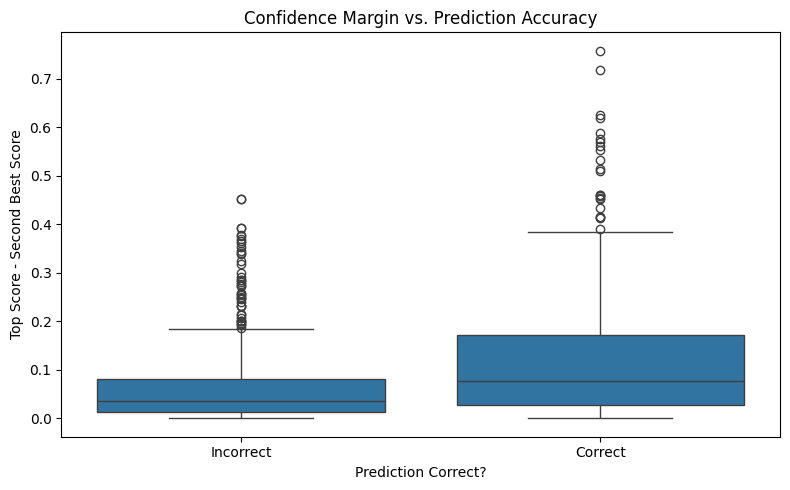

Average Confidence Margin (Correct): 0.1252496200017923
Average Confidence Margin (Incorrect): 0.06312858494001665


In [9]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your output file ===
df = pd.read_csv("output/alignment_eval_llama3.2.csv")

# === Normalize columns ===
df["Predicted"] = df["Predicted"].str.strip().str.upper()
df["CorrectAnswer"] = df["CorrectAnswer"].str.strip().str.upper()
df["IsCorrect"] = df["Predicted"] == df["CorrectAnswer"]

# === Parse Similarity Scores ===
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)

# === Compute metrics ===
df["TopScore"] = df["SimilarityScores"].apply(max)
df["TopIndex"] = df["SimilarityScores"].apply(lambda s: s.index(max(s)))
df["SecondScore"] = df["SimilarityScores"].apply(lambda s: sorted(s, reverse=True)[1])
df["ConfidenceMargin"] = df["TopScore"] - df["SecondScore"]

# === Distribution of Confidence by Correctness ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="IsCorrect", y="ConfidenceMargin")
plt.title("Confidence Margin vs. Prediction Accuracy")
plt.xlabel("Prediction Correct?")
plt.ylabel("Top Score - Second Best Score")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.tight_layout()
plt.show()

# === Optional: Print correlation
print("Average Confidence Margin (Correct):", df[df["IsCorrect"] == True]["ConfidenceMargin"].mean())
print("Average Confidence Margin (Incorrect):", df[df["IsCorrect"] == False]["ConfidenceMargin"].mean())


In [64]:
threshold = 0.4524092674256
confident = df[df["ConfidenceMargin"] > threshold]
print("Accuracy on confident predictions:", confident["IsCorrect"].mean())
print("Coverage (fraction of data kept):", len(confident) / len(df))
print(len(confident))


Accuracy on confident predictions: 1.0
Coverage (fraction of data kept): 0.016
16


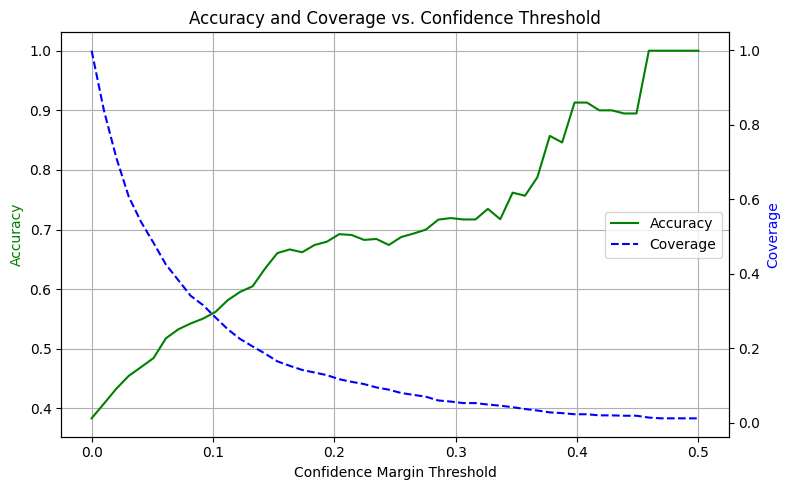

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of thresholds
thresholds = np.linspace(0, 0.5, 50)
accuracies = []
coverages = []

for t in thresholds:
    confident = df[df["ConfidenceMargin"] > t]
    if len(confident) == 0:
        acc = np.nan
    else:
        acc = confident["IsCorrect"].mean()
    accuracies.append(acc)
    coverages.append(len(confident) / len(df))

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax2 = ax1.twinx()
ax1.plot(thresholds, accuracies, color='green', label="Accuracy")
ax2.plot(thresholds, coverages, color='blue', linestyle='--', label="Coverage")

ax1.set_xlabel("Confidence Margin Threshold")
ax1.set_ylabel("Accuracy", color='green')
ax2.set_ylabel("Coverage", color='blue')

ax1.set_title("Accuracy and Coverage vs. Confidence Threshold")
ax1.grid(True)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()
